### Libraries to be used

In [55]:
import pandas as pd
import glob, os
import matplotlib.pyplot as plt
from transformers import pipeline
from __future__ import unicode_literals
import spacy,en_core_web_sm
from spacy.lang.en import English
from spacy.matcher import Matcher
import textacy
import string
from wordcloud import WordCloud, STOPWORDS 
import numpy as np
import nltk
import locationtagger
from difflib import SequenceMatcher
import gensim
from gensim.models import Word2Vec
from gensim import models
import seaborn as sns

### Class that contein all methods to answer the question

In [26]:
class MlSkillsOne:
    
    def __init__(self):
        pass
        self.all_records_raw_df = self.read_data_of_individual_topics()
        self.target_phrase = "Jeu de Paume is an excellent art gallery in Paris"        
        self.data_cleaner()
        self.get_score()
        self.corpus = self.all_records_raw_df['name'].map(lambda row: [row]).tolist()

    def read_data_of_individual_topics(self):

        path = 'data_prueba/'
        all_records = []

        for fname in glob.glob(path + '*.pickle'):
            obj = pd.read_pickle(fname)
            record = [obj['id'],obj['name'],obj['audience_size'],
                      obj['country'],obj['topic']]
            all_records = all_records + [record]
        
        all_records_df = pd.DataFrame.from_records(all_records)
        all_records_df.columns = ['id','name','audience_size','country','topic']
        
        return all_records_df
    
    def number_of_verb(self, string):
        verbs = []
        pattern = [{'POS': 'VERB', 'OP': '?'},\
               {'POS': 'VERB', 'OP': '+'}]
        doc = textacy.make_spacy_doc(string, lang='en_core_web_sm')
        lists = textacy.extract.matches.token_matches(doc, [pattern])
        for list in lists:
            verbs.append(list.text)
            
        return len(verbs)
    
    def number_of_letters(self, string):
        return len([i for i in string if i.isalpha()])
    
    def get_location(self, string):
        place_entity = locationtagger.find_locations(text = string)
        countries = place_entity.countries
        regions = place_entity.regions
        cities = place_entity.cities
        X = countries + regions + cities
        return X

    def similarity(self, row):
        return SequenceMatcher(None, row, self.target_phrase).ratio()
    
    def data_cleaner(self):

        self.all_records_raw_df["name_cleaned"] = self.all_records_raw_df.name\
            .apply(lambda row: row.translate(str.maketrans('', '', string.punctuation)))
        
        self.all_records_raw_df["number_of_verb"] = self.all_records_raw_df.name_cleaned\
            .apply(lambda row: self.number_of_verb(row))
        
        self.all_records_raw_df["number_words"] = self.all_records_raw_df.name_cleaned\
            .apply(lambda row: len(row.split()))
            
        self.all_records_raw_df["number_letters"] = self.all_records_raw_df.name_cleaned\
            .apply(lambda row: self.number_of_letters(row))
        
        self.all_records_raw_df["number_letters_words_verbs"] = self.all_records_raw_df.number_letters.\
            apply(lambda row: [row]) + self.all_records_raw_df.number_words.apply(lambda row: [row]) + \
            self.all_records_raw_df.number_of_verb.apply(lambda row: [row])
         
        self.all_records_raw_df["name_entity"] =  self.all_records_raw_df.name_cleaned\
            .apply(lambda row: self.get_location(row))  
         
        self.all_records_raw_df["similarity"] =  self.all_records_raw_df.name_cleaned\
            .apply(lambda row: self.similarity(row))
        
        self.all_records_raw_df["target_phrase"] = self.target_phrase
        
    def word_cloud(self):
        string = self.all_records_raw_df.name_cleaned
        comment_words = ''
        stopwords = set(STOPWORDS)
        for val in string:

            # typecaste each val to string
            val = str(val)

            # split the value
            tokens = val.split()

            # Converts each token into lowercase
            for i in range(len(tokens)):
                tokens[i] = tokens[i].lower()

            comment_words += " ".join(tokens)+" "

        wordcloud = WordCloud(width = 800, height = 800,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)

        # plot the WordCloud image                      
        plt.figure(figsize = (8, 8), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)

        plt.show()   
        
    def get_score(self):
        
        sentiment_pipeline = pipeline("sentiment-analysis",
                              model="nlptown/bert-base-multilingual-uncased-sentiment")
        
        self.all_records_raw_df["labels"] = self.all_records_raw_df.name_cleaned.\
                                            apply(lambda x: sentiment_pipeline(x))
        self.all_records_raw_df["score"] = self.all_records_raw_df.labels.\
                                            apply(lambda x: list(x[0].items())[0][1])
        self.all_records_raw_df.drop(["labels"], axis=1, inplace=True)
        


In [27]:
%%time
skills = MlSkillsOne()

Some layers from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at nlptown/bert-base-multilingual-uncased-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


CPU times: total: 39.2 s
Wall time: 32.7 s


In [28]:
skills.all_records_raw_df[skills.all_records_raw_df.score == '5 stars'].head(2)

,id,name,audience_size,country,topic,name_cleaned,number_of_verb,number_words,number_letters,number_letters_words_verbs,name_entity,similarity,target_phrase,score
0,6003407352218,#Te Amo,38302730,None,None,Te Amo,0,2,5,"[5, 2, 0]",[],0.109091,Jeu de Paume is an excellent art gallery in Paris,5 stars
1,6003195700298,(500) Days of Summer,456210,None,None,500 Days of Summer,0,4,12,"[12, 4, 0]",[],0.208955,Jeu de Paume is an excellent art gallery in Paris,5 stars


In [29]:
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

In [42]:
%%time
data_for_training = list(tagged_document(skills.corpus))
model = gensim.models.doc2vec.Doc2Vec(vector_size=1, min_count=1, epochs=30)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: total: 281 ms
Wall time: 212 ms


In [60]:
_df = skills.all_records_raw_df
_df["infer_vector"] = skills.all_records_raw_df["name"].\
                                                apply(lambda x: model.infer_vector([x]))
_df

,id,name,audience_size,country,topic,name_cleaned,number_of_verb,number_words,number_letters,number_letters_words_verbs,name_entity,similarity,target_phrase,score,infer_vector
0,6003407352218,#Te Amo,38302730,None,None,Te Amo,0,2,5,"[5, 2, 0]",[],0.109091,Jeu de Paume is an excellent art gallery in Paris,5 stars,[-0.0957793]
1,6003195700298,(500) Days of Summer,456210,None,None,500 Days of Summer,0,4,12,"[12, 4, 0]",[],0.208955,Jeu de Paume is an excellent art gallery in Paris,5 stars,[0.3890023]
2,6003258659267,10 000 a. C.,1329300,None,None,10 000 a C,0,4,2,"[2, 4, 0]",[],0.135593,Jeu de Paume is an excellent art gallery in Paris,3 stars,[0.20181707]
3,6002960102520,10 000 metros,3921990,None,None,10 000 metros,0,3,6,"[6, 3, 0]",[],0.225806,Jeu de Paume is an excellent art gallery in Paris,5 stars,[-0.2934558]
4,6003297136738,10 Barrel Brewing Company,58970,None,None,10 Barrel Brewing Company,0,4,20,"[20, 4, 0]",[],0.243243,Jeu de Paume is an excellent art gallery in Paris,5 stars,[0.29689887]
5,6002930409372,7-Eleven,48639900,None,None,7Eleven,0,1,6,"[6, 1, 0]",[],0.142857,Jeu de Paume is an excellent art gallery in Paris,5 stars,[-0.02662724]
6,6002972461374,7de Laan,529250,None,None,7de Laan,0,2,6,"[6, 2, 0]",[],0.210526,Jeu de Paume is an excellent art gallery in Paris,5 stars,[-0.40862417]
7,6003305718053,7th Heaven,1029140,None,None,7th Heaven,0,2,8,"[8, 2, 0]",[],0.169492,Jeu de Paume is an excellent art gallery in Paris,5 stars,[-0.014235026]
8,6002991655194,8 Ball Multiplayer Pool,3670,None,None,8 Ball Multiplayer Pool,0,4,19,"[19, 4, 0]",[Ball],0.222222,Jeu de Paume is an excellent art gallery in Paris,5 stars,[0.29358584]
9,6003473842964,8 Ball Pool,28714040,None,None,8 Ball Pool,0,3,8,"[8, 3, 0]",[],0.200000,Jeu de Paume is an excellent art gallery in Paris,5 stars,[0.030815719]


In [61]:
_df.infer_vector = _df.infer_vector.apply(lambda x:x[0])
_df

,id,name,audience_size,country,topic,name_cleaned,number_of_verb,number_words,number_letters,number_letters_words_verbs,name_entity,similarity,target_phrase,score,infer_vector
0,6003407352218,#Te Amo,38302730,None,None,Te Amo,0,2,5,"[5, 2, 0]",[],0.109091,Jeu de Paume is an excellent art gallery in Paris,5 stars,-0.095779
1,6003195700298,(500) Days of Summer,456210,None,None,500 Days of Summer,0,4,12,"[12, 4, 0]",[],0.208955,Jeu de Paume is an excellent art gallery in Paris,5 stars,0.389002
2,6003258659267,10 000 a. C.,1329300,None,None,10 000 a C,0,4,2,"[2, 4, 0]",[],0.135593,Jeu de Paume is an excellent art gallery in Paris,3 stars,0.201817
3,6002960102520,10 000 metros,3921990,None,None,10 000 metros,0,3,6,"[6, 3, 0]",[],0.225806,Jeu de Paume is an excellent art gallery in Paris,5 stars,-0.293456
4,6003297136738,10 Barrel Brewing Company,58970,None,None,10 Barrel Brewing Company,0,4,20,"[20, 4, 0]",[],0.243243,Jeu de Paume is an excellent art gallery in Paris,5 stars,0.296899
5,6002930409372,7-Eleven,48639900,None,None,7Eleven,0,1,6,"[6, 1, 0]",[],0.142857,Jeu de Paume is an excellent art gallery in Paris,5 stars,-0.026627
6,6002972461374,7de Laan,529250,None,None,7de Laan,0,2,6,"[6, 2, 0]",[],0.210526,Jeu de Paume is an excellent art gallery in Paris,5 stars,-0.408624
7,6003305718053,7th Heaven,1029140,None,None,7th Heaven,0,2,8,"[8, 2, 0]",[],0.169492,Jeu de Paume is an excellent art gallery in Paris,5 stars,-0.014235
8,6002991655194,8 Ball Multiplayer Pool,3670,None,None,8 Ball Multiplayer Pool,0,4,19,"[19, 4, 0]",[Ball],0.222222,Jeu de Paume is an excellent art gallery in Paris,5 stars,0.293586
9,6003473842964,8 Ball Pool,28714040,None,None,8 Ball Pool,0,3,8,"[8, 3, 0]",[],0.200000,Jeu de Paume is an excellent art gallery in Paris,5 stars,0.030816


In [62]:
_df['infer_vector'].min(),_df['infer_vector'].max()

(-0.4927719235420227, 0.44097235798835754)

In [71]:
_df[_df['infer_vector']  == '5 stars']

,id,name,audience_size,country,topic,name_cleaned,number_of_verb,number_words,number_letters,number_letters_words_verbs,name_entity,similarity,target_phrase,score,infer_vector


<AxesSubplot:xlabel='infer_vector', ylabel='Density'>

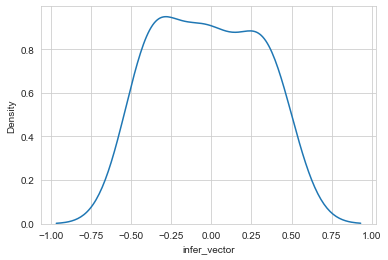

In [74]:
sns.set_style('whitegrid')
sns.kdeplot(data=_df.infer_vector[_df['score']  == '5 stars'])

<AxesSubplot:xlabel='infer_vector', ylabel='Count'>

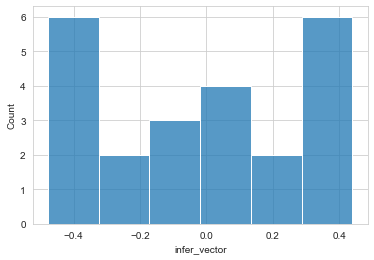

In [81]:
sns.set_style('whitegrid')
sns.histplot(data=_df.infer_vector[_df['score']  == '5 stars'])

<AxesSubplot:xlabel='infer_vector', ylabel='Density'>

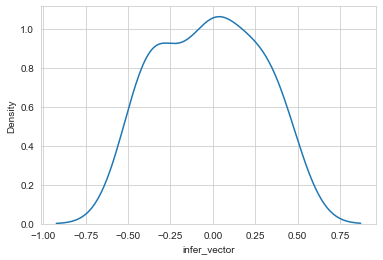

In [68]:
sns.set_style('whitegrid')
sns.kdeplot(data=_df['infer_vector'])

<AxesSubplot:xlabel='infer_vector', ylabel='Proportion'>

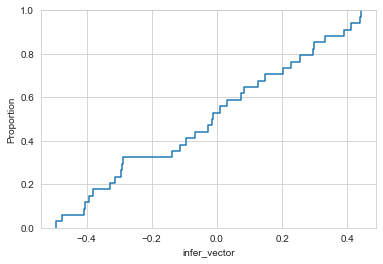

In [69]:
sns.ecdfplot(data=_df['infer_vector'])